# **Ouroboros fMRI: Predicting human brain activity with machine learning models**

#### Version: 10th March 2021

==============================================================================================

Project developed by Maël Donoso, Ph.D. in Cognitive and Computational Neuroscience. Affiliations: Ouroboros Neurotechnologies, Institut Lémanique du Cerveau (https://institut-cerveau.ch/), Policlinique Ostéopathique de Lausanne (https://policlinique-osteopathique-lausanne.ch/). 

The first version of this project (17th February 2021) was presented as a Capstone Project for the COS in Applied Data Science: Machine Learning of the EPFL Extension School (https://www.extensionschool.ch/).

==============================================================================================

This project is presented through six Notebooks:

*01: Data Analysis*

*02: Classification* (all classification models except neural networks)

*03: Neural Networks*

*04: Regression*

*05: Results*

***06: Complements***

==============================================================================================

### Notebook 06

# **Complements**

## **1. Introduction to Complements**

In this Notebook, we will divide our statistical maps into **brain regions**, roughly defined as cubes of a certain size, and run **classification models** on these regions. In other words, we will use only a selection of our brain data to classify the statistical maps of the test set. The objective is to verify whether some regions are a **better basis for classification** than others, which would mean that these regions contain more relevant information for distinguishing between the good, neutral and bad conditions. We will also run **regression models** on these regions, and compute a predictability map similar to the one obtained in the Notebook about Regression. Finally, we will compare the **regions accuracy for classification and prediction**. 

## **2. Functions**

In the following cells, we define a series of functions that will be helpful throughout the Notebook to **extract data from the features arrays**, **verify the proportion of zero values**, **run models** and **display graphs**. 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Define a function to extract the features array for a given region. 
def extract_features(X_convnet, regions_image_data, region):
    X = np.zeros((X_convnet.shape[0], np.sum(regions_image_data == region)))
    for image_index in range(0, X_convnet.shape[0]):
        convnet_image = X_convnet[image_index, :, :, :]
        flatten_image = convnet_image[regions_image_data == region].flatten()
        X[image_index, :] = flatten_image
    return X

In [3]:
# Define a function to verify if the proportion of voxels with systematic zero values stays under a certain threshold in a given region. 
def verify_all_zeros(X, regions_image_data, region, threshold = 0.5):
    # Retrieve all the indexes where the features always equal zero. 
    # We use the 'any' method, which returns True for non-zero numbers and False for zero numbers. 
    all_zeros_idx = ~X.any(axis = 0)

    # Verify if the number of features that always equal zero is under the threshold. 
    if np.sum(all_zeros_idx) > threshold * np.sum(regions_image_data == region):
        return 0
    else:
        return 1

In [4]:
# Define a function to run a classification model on all regions. 
def run_classification_model_on_regions(pipe, regions_image_data, region_indexes, regions_over_threshold, X_convnet, X_convnet_te, y, y_te):
    scores = np.zeros((region_indexes.shape[0], 3))
    counter = 0

    # Loop through all the regions. 
    for region in region_indexes:
        # Information. 
        if counter % 100 == 0:
            print('Step ' + str(int(counter/100)) + '/' + str(np.ceil(region_indexes.shape[0]/100).astype(int)))

        # Verify if the number of non-zero values in this region is over the threshold. 
        if regions_over_threshold[counter] == 1:
            # Extract the data from the selected region. 
            X = extract_features(X_convnet, regions_image_data, region)
            X_te = extract_features(X_convnet_te, regions_image_data, region)
            
            # Fit model. 
            pipe.fit(X, y)

            # Compute and save the test score. 
            test_score = pipe.score(X_te, y_te)
            scores[counter, 0] = region
            scores[counter, 1] = test_score
            scores[counter, 2] = 1
            
        else:
            scores[counter, 0] = region
            scores[counter, 1] = 1 / 3
            scores[counter, 2] = 0

        # Increment counter. 
        counter += 1
        
    print('Done.')
    return scores

In [5]:
# Define a function to display the results with histograms. 
def display_histograms(scores):
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))
    axes[0].hist(scores[:, 1], bins = 40)
    axes[0].set_title('Including regions with high proportion of zeros')
    axes[1].hist(scores[scores[:, 2] == 1, 1], bins = 40)
    axes[1].set_title('Excluding regions with high proportion of zeros');

In [6]:
# Define a function to find the median voxel of a region. 
def median_voxel_of_region(regions_image_data, region):
    x_indexes = np.unique(np.where(regions_image_data == region)[0])
    y_indexes = np.unique(np.where(regions_image_data == region)[1])
    z_indexes = np.unique(np.where(regions_image_data == region)[2])
    x_median_coord = np.median(x_indexes)
    y_median_coord = np.median(y_indexes)
    z_median_coord = np.median(z_indexes)
    return (x_median_coord, y_median_coord, z_median_coord)

In [7]:
# Define a function to display the position of a region, with one image as background. 
def display_region_position(voxel_index, background_image, image_data_shape, factor):
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))
    fig.suptitle('Region median coordinates: ' + str(voxel_index), y = 0.98, fontsize = 14)

    # Sagittal view. 
    axes[0].imshow(background_image[np.ceil(voxel_index[0]).astype(int), :, :].T, origin = 'lower')
    axes[0].axhline(voxel_index[2], 0, image_data_shape[1], color = 'yellow') # Horizontal line through coronal view. 
    axes[0].axvline(voxel_index[1], 0, image_data_shape[2], color = 'yellow') # Vertical line through axial view. 
    axes[0].scatter(voxel_index[1], voxel_index[2], marker = 'o', c = 'white')
    # Square around the region. 
    xlim_start = (voxel_index[1] - (factor / 2)) / image_data_shape[1]
    xlim_end =   (voxel_index[1] + (factor / 2)) / image_data_shape[1]
    ylim_start = (voxel_index[2] - (factor / 2)) / image_data_shape[2]
    ylim_end =   (voxel_index[2] + (factor / 2)) / image_data_shape[2]
    axes[0].axhline(voxel_index[2] - (factor / 2), xlim_start, xlim_end, color = 'yellow')
    axes[0].axhline(voxel_index[2] + (factor / 2), xlim_start, xlim_end, color = 'yellow')
    axes[0].axvline(voxel_index[1] - (factor / 2), ylim_start, ylim_end, color = 'yellow')
    axes[0].axvline(voxel_index[1] + (factor / 2), ylim_start, ylim_end, color = 'yellow')
    # Title. 
    axes[0].set_title('Sagittal view')

    # Coronal view. 
    axes[1].imshow(background_image[:, np.ceil(voxel_index[1]).astype(int), :].T, origin = 'lower')
    axes[1].axhline(voxel_index[2], 0, image_data_shape[0], color = 'yellow') # Horizontal line through sagittal view. 
    axes[1].axvline(voxel_index[0], 0, image_data_shape[2], color = 'yellow') # Vertical line through axial view. 
    axes[1].scatter(voxel_index[0], voxel_index[2], marker = 'o', c = 'white')
    # Square around the region. 
    xlim_start = (voxel_index[0] - (factor / 2)) / image_data_shape[0]
    xlim_end =   (voxel_index[0] + (factor / 2)) / image_data_shape[0]
    ylim_start = (voxel_index[2] - (factor / 2)) / image_data_shape[2]
    ylim_end =   (voxel_index[2] + (factor / 2)) / image_data_shape[2]
    axes[1].axhline(voxel_index[2] - (factor / 2), xlim_start, xlim_end, color = 'yellow')
    axes[1].axhline(voxel_index[2] + (factor / 2), xlim_start, xlim_end, color = 'yellow')
    axes[1].axvline(voxel_index[0] - (factor / 2), ylim_start, ylim_end, color = 'yellow')
    axes[1].axvline(voxel_index[0] + (factor / 2), ylim_start, ylim_end, color = 'yellow')
    # Title. 
    axes[1].set_title('Coronal view')

    # Axial view. 
    axes[2].imshow(background_image[:, :, np.ceil(voxel_index[2]).astype(int)], origin = 'lower')
    axes[2].axhline(voxel_index[0], 0, image_data_shape[1], color = 'yellow') # Horizontal line through coronal view. 
    axes[2].axvline(voxel_index[1], 0, image_data_shape[0], color = 'yellow') # Vertical line through sagittal view. 
    axes[2].scatter(voxel_index[1], voxel_index[0], marker = 'o', c = 'white')
    # Square around the region. 
    xlim_start = (voxel_index[1] - (factor / 2)) / image_data_shape[1]
    xlim_end =   (voxel_index[1] + (factor / 2)) / image_data_shape[1]
    ylim_start = (voxel_index[0] - (factor / 2)) / image_data_shape[0]
    ylim_end =   (voxel_index[0] + (factor / 2)) / image_data_shape[0]
    axes[2].axhline(voxel_index[0] - (factor / 2), xlim_start, xlim_end, color = 'yellow')
    axes[2].axhline(voxel_index[0] + (factor / 2), xlim_start, xlim_end, color = 'yellow')
    axes[2].axvline(voxel_index[1] - (factor / 2), ylim_start, ylim_end, color = 'yellow')
    axes[2].axvline(voxel_index[1] + (factor / 2), ylim_start, ylim_end, color = 'yellow')
    # Title. 
    axes[2].set_title('Axial view')
    plt.show();

In [8]:
# Define the Residual Sum of Squares function. 
def RSS(y, y_pred):
    return np.sum(np.square(y - y_pred))

## **3. Data import**

In this Notebook, we **reuse the 3D arrays** that we used for the convolutional neural networks, because we need to define 3D regions for our analysis, and because we want to display the position of the best regions found by our models. Therefore, we will have to perform again some preprocessing: flatten the arrays and remove all the regions when a certain proportion of their voxels are always equal to zero. 

In [9]:
# Define the preprocessed data path. 
preprocessed_data_path = '../ouroboros_fmri_preprocessed_data/'

# Define the results path. If empty, the results will be saved in the current directory. 
results_path = ''

In [10]:
# Select rescale mode. 
# 1: original data | 2, 3, 4: voxel size rescaled by a factor 2, 3 or 4. 
rescale_mode = 1

In [11]:
# Load data. 
with np.load(preprocessed_data_path + 'datasets_for_machine_learning.npz', allow_pickle = False) as npz_file:
    data_dict = dict(npz_file.items())
rescale_modes_list = ['', '_r2', '_r3', '_r4']
    
# Features of the train+valid dataset. 
X_convnet = data_dict['features_convnet' + rescale_modes_list[rescale_mode - 1] + '_tr']

# Features of the test dataset. 
X_convnet_te = data_dict['features_convnet' + rescale_modes_list[rescale_mode - 1] + '_te']

# Target variables. 
y = data_dict['target_tr']
y_te = data_dict['target_te']

In [12]:
# Display the size of the arrays. 
print('X_convnet:   ', X_convnet.shape)
print('X_convnet_te:', X_convnet_te.shape)
print('y:           ', y.shape)
print('y_te:        ', y_te.shape)

X_convnet:    (120, 91, 109, 91)
X_convnet_te: (36, 91, 109, 91)
y:            (120,)
y_te:         (36,)


## **4. Classification models on brain regions**

### 4.1 Map of regions

In the following cells, we create a **map of regions** defined by a certain factor. Since our regions are cubic, this factor corresponds simply to the **edge of the cubes**. Specifically, we assign an **index** to each region, and create a map with the same dimensions as our statistical maps, where each voxel contains the index of the region to which this voxel belongs. As we saw in the previous Notebooks, some voxels are always equal to NaN/zero in all statistical maps, therefore they do not contain any relevant information. For each region, we verify if the proportion of such voxels stays under a certain **threshold**, by default 50%. Our classification and regression models will be run only on the regions containing enough non-zero values. 

In [13]:
# Display the shape of the first image data array. 
image_data = X_convnet[0, :, :, :]
image_data.shape

(91, 109, 91)

In [14]:
# Create a map of regions defined by a certain factor. 
factor = 10
one_region = np.ones((factor, factor, factor))
region_index = 0

# Loop over all dimensions of the map, and concatenate volumes successively along axes 0, 1 and 2. 
for z_range in range(0, np.ceil(image_data.shape[2] / factor).astype(int)):
    for y_range in range(0, np.ceil(image_data.shape[1] / factor).astype(int)):
        for x_range in range(0, np.ceil(image_data.shape[0] / factor).astype(int)):
            # During the first iteration, create one region with the correct index. 
            # Then, concatenate the following regions along axis = 0. 
            if x_range == 0:
                x_regions = region_index * one_region
            else:
                x_regions = np.concatenate((x_regions, region_index * one_region), axis = 0)
            region_index += 1
        # During the first iteration, use the regions created along axis = 0. 
        # Then, concatenate the following blocks of regions along axis = 1. 
        if y_range == 0:
            y_regions = x_regions
        else:
            y_regions = np.concatenate((y_regions, x_regions), axis = 1)
    # During the first iteration, use the block of regions created along axis = 1. 
    # Then, concatenate the following "blocks of blocks" of regions along axis = 2. 
    if z_range == 0:
        z_regions = y_regions
    else:
        z_regions = np.concatenate((z_regions, y_regions), axis = 2)
        
# Save the last concatenation as the map of regions, and display its size. 
regions_image_data = z_regions
regions_image_data.shape

(100, 110, 100)

In [15]:
# Resize the array according to the size of a statistical map, and display the new size. 
regions_image_data = regions_image_data[0:image_data.shape[0], 0:image_data.shape[1], 0:image_data.shape[2]]
regions_image_data.shape

(91, 109, 91)

In [16]:
# Get the region indexes, and display the first ones. 
region_indexes = np.unique(regions_image_data.flatten())
region_indexes[0:50]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49.])

In [17]:
# Display the number of regions. 
region_indexes.shape[0]

1100

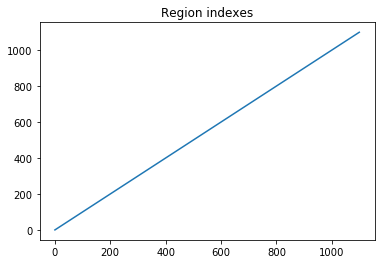

In [18]:
# Display the region indexes in a graph. 
plt.plot(region_indexes)
plt.title('Region indexes');

In [19]:
# Verify that the region indexes correspond to a list of integers sorted in ascending order. 
np.sum(region_indexes == list(range(0, region_indexes.shape[0]))) == region_indexes.shape[0]

True

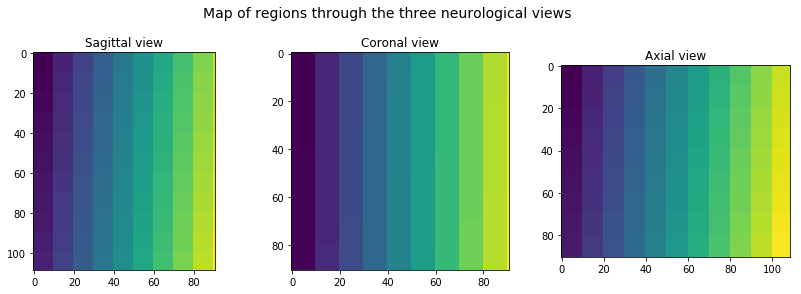

In [20]:
# Verify that the map of regions is indeed composed of a series of regions with incremental indexes along the three axes. 
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (14, 4))
fig.suptitle('Map of regions through the three neurological views', y = 1.04, fontsize = 14)
axes[0].imshow(regions_image_data[0, :, :])
axes[0].set_title('Sagittal view')
axes[1].imshow(regions_image_data[:, 0, :])
axes[1].set_title('Coronal view')
axes[2].imshow(regions_image_data[:, :, 0])
axes[2].set_title('Axial view');

In [21]:
# Find the regions over a certain threshold of non-zero values. 
regions_over_threshold = np.zeros(region_indexes.shape[0])
counter = 0

# Loop through all the regions. 
for region in region_indexes:
    # Information. 
    if counter % 100 == 0:
        print('Step ' + str(int(counter/100)) + '/' + str(np.ceil(region_indexes.shape[0]/100).astype(int)))
    
    # Extract the data and verify the number of non-zero values. 
    X = extract_features(X_convnet, regions_image_data, region)
    regions_over_threshold[counter] = verify_all_zeros(X, regions_image_data, region)
    counter += 1

print('Done.')

Step 0/11
Step 1/11
Step 2/11
Step 3/11
Step 4/11
Step 5/11
Step 6/11
Step 7/11
Step 8/11
Step 9/11
Step 10/11
Done.


In [22]:
# Display statistics about the number of systematic zero values in the regions. 
print(str(region_indexes.shape[0]) + ' regions in total, including:')
print('-> ' + str(np.sum(regions_over_threshold == 1)) + ' regions with low proportion of systematic zero values')
print('-> ' + str(np.sum(regions_over_threshold == 0)) + ' regions with high proportion of systematic zero values')

1100 regions in total, including:
-> 247 regions with low proportion of systematic zero values
-> 853 regions with high proportion of systematic zero values


### 4.2 K-Nearest Neighbors (k-NN)

In this section and the following ones, we run a series of **classification models** and display the **test scores** of our regions. For each model, we also represent the position of the **best region** according to these scores. 

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [24]:
# Create pipeline. 
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_jobs = -1))
])

# Run model. 
scores_knn = run_classification_model_on_regions(pipe_knn, regions_image_data, region_indexes, regions_over_threshold, 
                                                 X_convnet, X_convnet_te, y, y_te)

Step 0/11
Step 1/11
Step 2/11
Step 3/11
Step 4/11
Step 5/11
Step 6/11
Step 7/11
Step 8/11
Step 9/11
Step 10/11
Done.


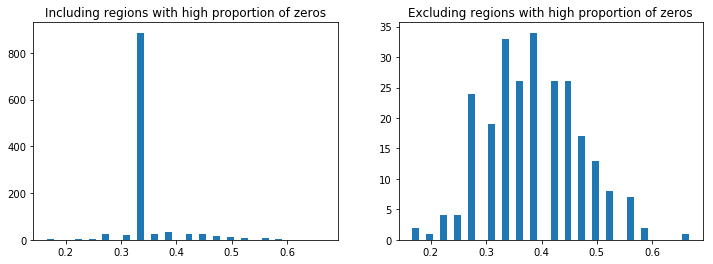

In [25]:
# Display results. 
display_histograms(scores_knn)

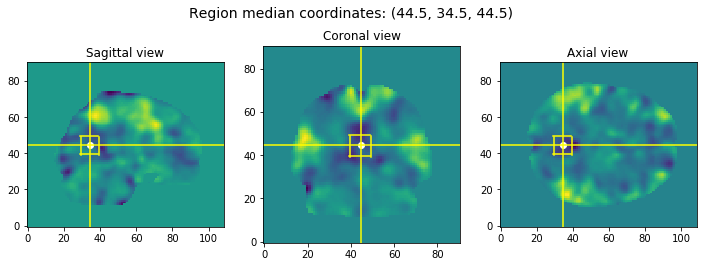

In [26]:
# Find the coordinates of the best region for classification. 
best_region_index = scores_knn[np.argmax(scores_knn[:, 1]), 0].astype(int)
best_region_coordinates = median_voxel_of_region(regions_image_data, best_region_index)

# Display the position of this region. 
display_region_position(best_region_coordinates, image_data, image_data.shape, factor)

### 4.3 Decision tree

In [27]:
from sklearn.tree import DecisionTreeClassifier

In [28]:
# Create pipeline. 
pipe_dt = Pipeline([
    ('scaler', None),
    ('dt', DecisionTreeClassifier(criterion = 'gini', random_state = 0))
])

# Run model. 
scores_dt = run_classification_model_on_regions(pipe_dt, regions_image_data, region_indexes, regions_over_threshold, 
                                                X_convnet, X_convnet_te, y, y_te)

Step 0/11
Step 1/11
Step 2/11
Step 3/11
Step 4/11
Step 5/11
Step 6/11
Step 7/11
Step 8/11
Step 9/11
Step 10/11
Done.


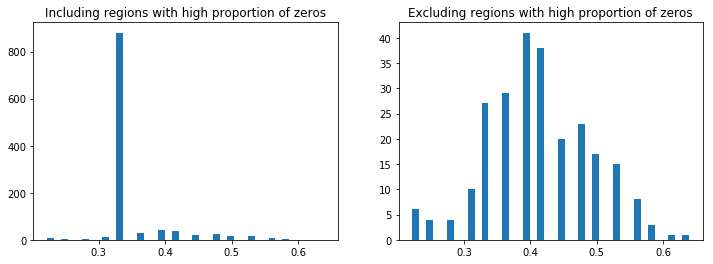

In [29]:
# Display results. 
display_histograms(scores_dt)

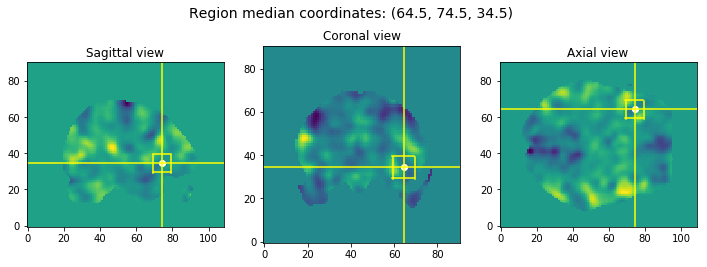

In [30]:
# Find the coordinates of the best region for classification. 
best_region_index = scores_dt[np.argmax(scores_dt[:, 1]), 0].astype(int)
best_region_coordinates = median_voxel_of_region(regions_image_data, best_region_index)

# Display the position of this region. 
display_region_position(best_region_coordinates, image_data, image_data.shape, factor)

### 4.4 Random forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
# Create pipeline. 
pipe_rf = Pipeline([
    ('scaler', None),
    ('rf', RandomForestClassifier(n_estimators = 10, max_depth = None, n_jobs = -1, random_state = 0))
])

# Run model. 
scores_rf = run_classification_model_on_regions(pipe_rf, regions_image_data, region_indexes, regions_over_threshold, 
                                                X_convnet, X_convnet_te, y, y_te)

Step 0/11
Step 1/11
Step 2/11
Step 3/11
Step 4/11
Step 5/11
Step 6/11
Step 7/11
Step 8/11
Step 9/11
Step 10/11
Done.


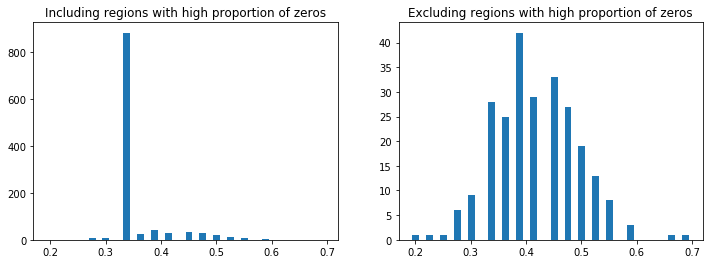

In [33]:
# Display results. 
display_histograms(scores_rf)

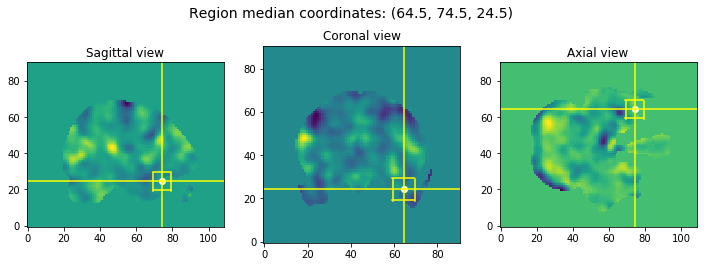

In [34]:
# Find the coordinates of the best region for classification. 
best_region_index = scores_rf[np.argmax(scores_rf[:, 1]), 0].astype(int)
best_region_coordinates = median_voxel_of_region(regions_image_data, best_region_index)

# Display the position of this region. 
display_region_position(best_region_coordinates, image_data, image_data.shape, factor)

### 4.5 Support Vector Machine (SVM) with linear kernel

In [35]:
from sklearn.svm import SVC

In [36]:
# Create pipeline. 
pipe_svm_linear = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel = 'linear', random_state = 0))
])

# Run model. 
scores_svm_linear = run_classification_model_on_regions(pipe_svm_linear, regions_image_data, region_indexes, regions_over_threshold, 
                                                        X_convnet, X_convnet_te, y, y_te)

Step 0/11
Step 1/11
Step 2/11
Step 3/11
Step 4/11
Step 5/11
Step 6/11
Step 7/11
Step 8/11
Step 9/11
Step 10/11
Done.


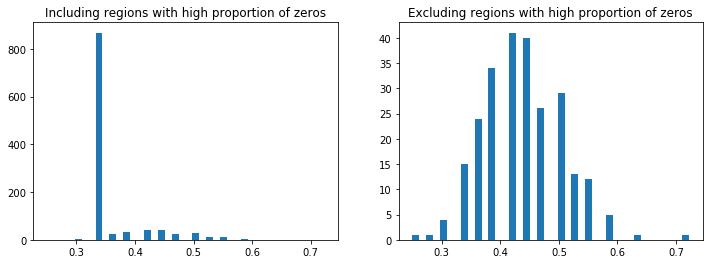

In [37]:
# Display results. 
display_histograms(scores_svm_linear)

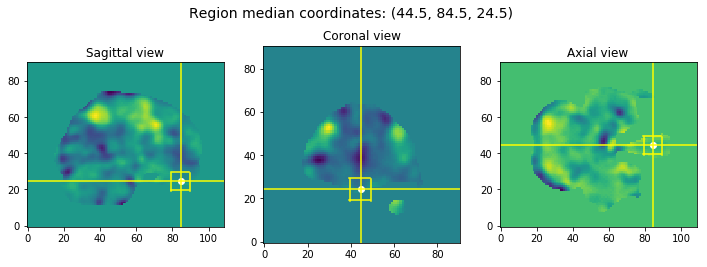

In [38]:
# Find the coordinates of the best region for classification. 
best_region_index = scores_svm_linear[np.argmax(scores_svm_linear[:, 1]), 0].astype(int)
best_region_coordinates = median_voxel_of_region(regions_image_data, best_region_index)

# Display the position of this region. 
display_region_position(best_region_coordinates, image_data, image_data.shape, factor)

### 4.6 Support Vector Machine (SVM) with RBF kernel

In [39]:
# Create pipeline. 
pipe_svm_rbf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel = 'rbf', gamma = 'auto', random_state = 0))
])

# Run model. 
scores_svm_rbf = run_classification_model_on_regions(pipe_svm_rbf, regions_image_data, region_indexes, regions_over_threshold, 
                                                     X_convnet, X_convnet_te, y, y_te)

Step 0/11
Step 1/11
Step 2/11
Step 3/11
Step 4/11
Step 5/11
Step 6/11
Step 7/11
Step 8/11
Step 9/11
Step 10/11
Done.


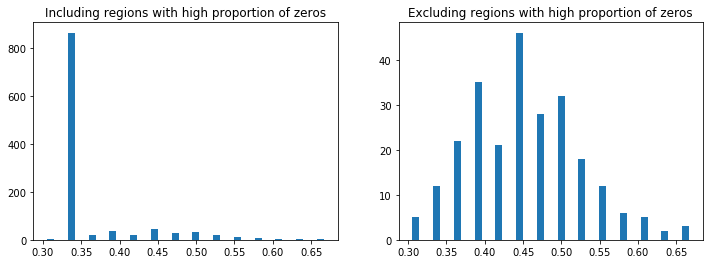

In [40]:
# Display results. 
display_histograms(scores_svm_rbf)

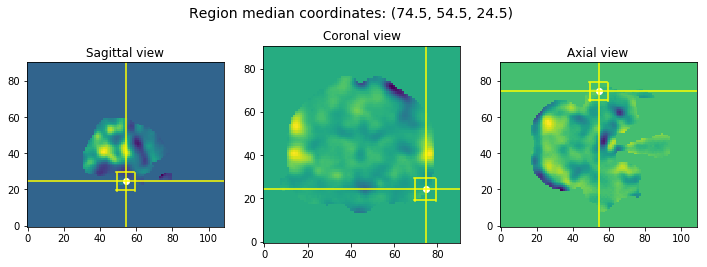

In [41]:
# Find the coordinates of the best region for classification. 
best_region_index = scores_svm_rbf[np.argmax(scores_svm_rbf[:, 1]), 0].astype(int)
best_region_coordinates = median_voxel_of_region(regions_image_data, best_region_index)

# Display the position of this region. 
display_region_position(best_region_coordinates, image_data, image_data.shape, factor)

### 4.7 Logistic regression with multinomial strategy

In [42]:
from sklearn.linear_model import LogisticRegression

In [43]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Filter convergence warnings
warnings.simplefilter('ignore', ConvergenceWarning)

In [44]:
# Create pipeline. 
pipe_logreg_multinomial = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(multi_class = 'multinomial', solver = 'saga', n_jobs = -1, random_state = 0))
])

# Run model. 
scores_logreg_multinomial = run_classification_model_on_regions(pipe_logreg_multinomial, regions_image_data, region_indexes, regions_over_threshold, 
                                                                X_convnet, X_convnet_te, y, y_te)

Step 0/11
Step 1/11
Step 2/11
Step 3/11
Step 4/11
Step 5/11
Step 6/11
Step 7/11
Step 8/11
Step 9/11
Step 10/11
Done.


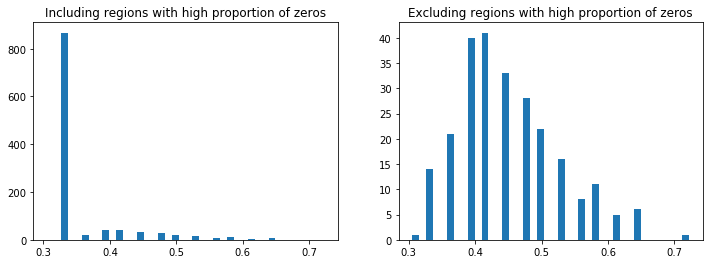

In [45]:
# Display results. 
display_histograms(scores_logreg_multinomial)

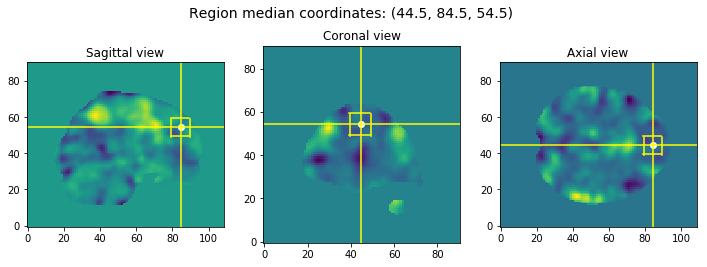

In [46]:
# Find the coordinates of the best region for classification. 
best_region_index = scores_logreg_multinomial[np.argmax(scores_logreg_multinomial[:, 1]), 0].astype(int)
best_region_coordinates = median_voxel_of_region(regions_image_data, best_region_index)

# Display the position of this region. 
display_region_position(best_region_coordinates, image_data, image_data.shape, factor)

### 4.8 Logistic regression with OVR strategy

In [47]:
# Create pipeline. 
pipe_logreg_ovr = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(multi_class = 'ovr', solver = 'liblinear', random_state = 0))
])

# Run model. 
scores_logreg_ovr = run_classification_model_on_regions(pipe_logreg_ovr, regions_image_data, region_indexes, regions_over_threshold, 
                                                        X_convnet, X_convnet_te, y, y_te)

Step 0/11
Step 1/11
Step 2/11
Step 3/11
Step 4/11
Step 5/11
Step 6/11
Step 7/11
Step 8/11
Step 9/11
Step 10/11
Done.


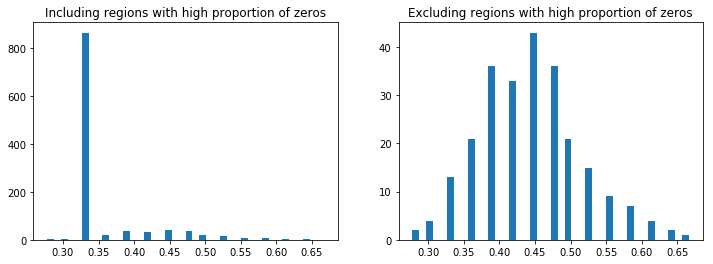

In [48]:
# Display results. 
display_histograms(scores_logreg_ovr)

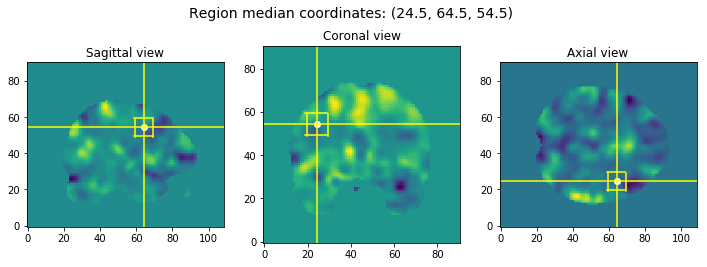

In [49]:
# Find the coordinates of the best region for classification. 
best_region_index = scores_logreg_ovr[np.argmax(scores_logreg_ovr[:, 1]), 0].astype(int)
best_region_coordinates = median_voxel_of_region(regions_image_data, best_region_index)

# Display the position of this region. 
display_region_position(best_region_coordinates, image_data, image_data.shape, factor)

### 4.9 Classification results

In the following cells, we **compare the results of similar models**, specifically: SVM with linear and RBF kernels, and logistic regression with multinomial and OVR strategies. We also find the **best region for classification** by averaging the results of all the classification models, and display the position of this region. 

In [50]:
import seaborn as sns

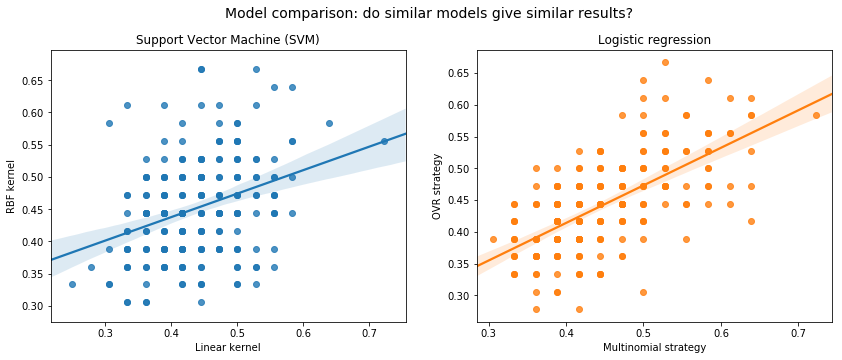

In [51]:
# Display scatter plots to verify if similar models give similar results. 
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 5))
fig.suptitle('Model comparison: do similar models give similar results?', y = 1, fontsize = 14)

# Compare SVM with linear and RBF kernels. 
sns.regplot(scores_svm_linear[scores_svm_linear[:, 2] == 1, 1], scores_svm_rbf[scores_svm_rbf[:, 2] == 1, 1], ax = axes[0])
axes[0].set_title('Support Vector Machine (SVM)')
axes[0].set_xlabel('Linear kernel')
axes[0].set_ylabel('RBF kernel')

# Compare logistic regression with multinomial and OVR strategies. 
sns.regplot(scores_logreg_multinomial[scores_logreg_multinomial[:, 2] == 1, 1], scores_logreg_ovr[scores_logreg_ovr[:, 2] == 1, 1], ax = axes[1])
axes[1].set_title('Logistic regression')
axes[1].set_xlabel('Multinomial strategy')
axes[1].set_ylabel('OVR strategy');

**Result:** There is a certain correlation between the SVM models with linear and RBF kernels, and between the logistic regression models with multinomial and OVR strategies. 

In [52]:
# Average the scores from all the classification models and display the best region for classification. 
scores_classification_models = (scores_knn[:, 1] + scores_dt[:, 1] + scores_rf[:, 1] + scores_svm_linear[:, 1] + scores_svm_rbf[:, 1] + scores_logreg_multinomial[:, 1] + scores_logreg_ovr[:, 1]) / 7
best_classification_region_index = np.argmax(scores_classification_models)
best_classification_region_index

406

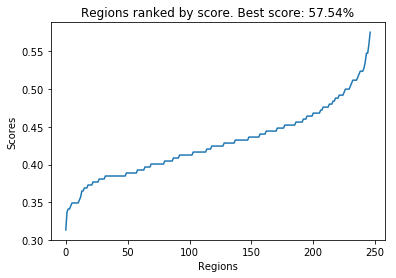

In [53]:
# Display the results with a plot. 
plt.plot(np.sort(scores_classification_models[regions_over_threshold == 1]))
plt.xlabel('Regions')
plt.ylabel('Scores')
plt.title('Regions ranked by score. Best score: ' + str(np.round(100 * scores_classification_models[best_classification_region_index], 2)) + '%');

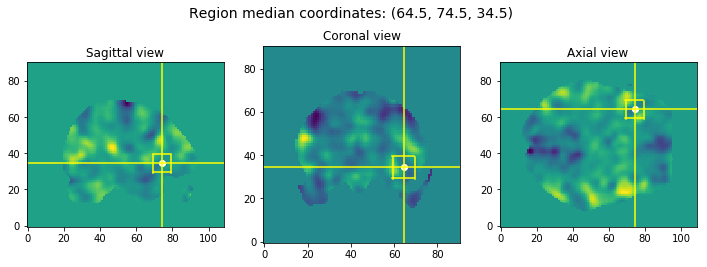

In [54]:
# Display the position of the best region for classification. 
best_region_coordinates = median_voxel_of_region(regions_image_data, best_classification_region_index)
display_region_position(best_region_coordinates, image_data, image_data.shape, factor)

## **5. Regression models on brain regions**

### 5.1 Predictability map

In the following cells, we compute a **predictability map** similar to the one from the Notebook about Regression. Instead of using our preprocessed dataset with a rescaled voxel size of 4, we compute the **average value for each region** and perform the same steps. Then, we find the **best region for regression** by retrieving the region with the maximum R^2 coefficient, and we display the position of this region. 

In [55]:
from sklearn.linear_model import LinearRegression

In [56]:
# Create the NumPy arrays to store the mean voxel value of the regions. 
X_regression_base = np.zeros((X_convnet.shape[0], region_indexes.shape[0]))
X_regression_base_te = np.zeros((X_convnet_te.shape[0], region_indexes.shape[0]))
counter = 0

# Loop through all the regions. 
for region in region_indexes:
    # Information. 
    if counter % 100 == 0:
        print('Step ' + str(int(counter/100)) + '/' + str(np.ceil(region_indexes.shape[0]/100).astype(int)))
    
    # Loop through all images of the train set. 
    for image_index in range(0, X_convnet.shape[0]):
        convnet_image = X_convnet[image_index, :, :, :]
        flatten_image = convnet_image[regions_image_data == region].flatten()
        X_regression_base[image_index, counter] = np.mean(flatten_image)
    
    # Loop through all images of the test set. 
    for image_index in range(0, X_convnet_te.shape[0]):
        convnet_image = X_convnet_te[image_index, :, :, :]
        flatten_image = convnet_image[regions_image_data == region].flatten()
        X_regression_base_te[image_index, counter] = np.mean(flatten_image)
        
    # Increment counter. 
    counter += 1

Step 0/11
Step 1/11
Step 2/11
Step 3/11
Step 4/11
Step 5/11
Step 6/11
Step 7/11
Step 8/11
Step 9/11
Step 10/11


In [57]:
# Compute the predictability map. 
predictability_map = np.zeros(region_indexes.shape[0])
counter = 0

# Loop through all the regions. 
for region in region_indexes:
    # Verify if the number of non-zero values in this region is over the threshold. 
    if regions_over_threshold[counter] == 1:
        # Extract the target variable. 
        y_regression = X_regression_base[:, counter]
        y_regression_te = X_regression_base_te[:, counter]

        # Remove the target variable from the features arrays. 
        X_regression = np.delete(X_regression_base, counter, 1)
        X_regression_te = np.delete(X_regression_base_te, counter, 1)

        # Compute the baseline. 
        rss_baseline_region = RSS(y_regression_te, np.mean(y_regression))

        # Linear regression. 
        lr_region = LinearRegression()
        lr_region.fit(X_regression, y_regression)
        y_pred_lr_region = lr_region.predict(X_regression_te)

        # Compute the R^2 measure and save it in the predictability map. 
        rss_lr_region = RSS(y_regression_te, y_pred_lr_region)
        r2_lr_region = 1 - (rss_lr_region / rss_baseline_region)
        predictability_map[counter] = r2_lr_region
        
    # Increment counter. 
    counter += 1

### 5.2 Regression results

In the following cells, we find the **best region for regression** by retrieving the region with the highest R^2 coefficient, and we display the position of this region. 

In [58]:
# Display the best region for regression. 
best_regression_region_index = np.argmax(predictability_map)
best_regression_region_index

703

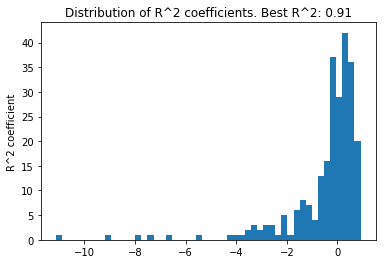

In [59]:
# Display the results with a histogram. 
plt.hist(predictability_map[regions_over_threshold == 1], bins = 50)
plt.ylabel('R^2 coefficient')
plt.title('Distribution of R^2 coefficients. Best R^2: ' + str(np.round(predictability_map[best_regression_region_index], 2)));

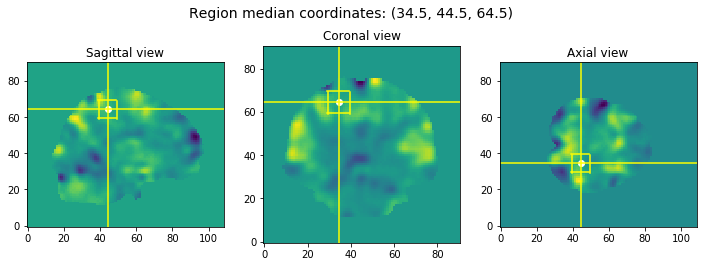

In [60]:
# Display the position of the best region for regression. 
best_region_coordinates = median_voxel_of_region(regions_image_data, best_regression_region_index)
display_region_position(best_region_coordinates, image_data, image_data.shape, factor)

## **6. Regions accuracy for classification and prediction**

In the following cells, we compare our previous results for each region, and display scatter plots showing the **regions accuracy for classification and prediction**. For the classification task, the accuracy corresponds to the correctness of the test set classification. For the regression task, the accuracy corresponds to the R^2 coefficient, reflecting how much of the activity of this region is predictable from the activity of all the other regions of the brain. 

In [61]:
# Select only the regions with non-zero values over the threshold, and showing a positive R^2 coefficient. 
positive_R2_predictability_map = predictability_map[(predictability_map > 0) & (regions_over_threshold == 1)]
positive_R2_scores_classification_models = scores_classification_models[(predictability_map > 0) & (regions_over_threshold == 1)]

# Select only the regions with non-zero values over the threshold, and showing a negative or zero R^2 coefficient. 
negative_R2_predictability_map = predictability_map[(predictability_map <= 0) & (regions_over_threshold == 1)]
negative_R2_scores_classification_models = scores_classification_models[(predictability_map <= 0) & (regions_over_threshold == 1)]

# Display the number of regions that satisfy the rules. 
print(str(predictability_map[regions_over_threshold == 1].shape[0]) + ' regions with non-zero values over the threshold, including:')
print('-> ' + str(positive_R2_predictability_map.shape[0]) + ' regions with positive R^2')
print('-> ' + str(negative_R2_predictability_map.shape[0]) + ' regions with negative R^2')

247 regions with non-zero values over the threshold, including:
-> 122 regions with positive R^2
-> 125 regions with negative R^2


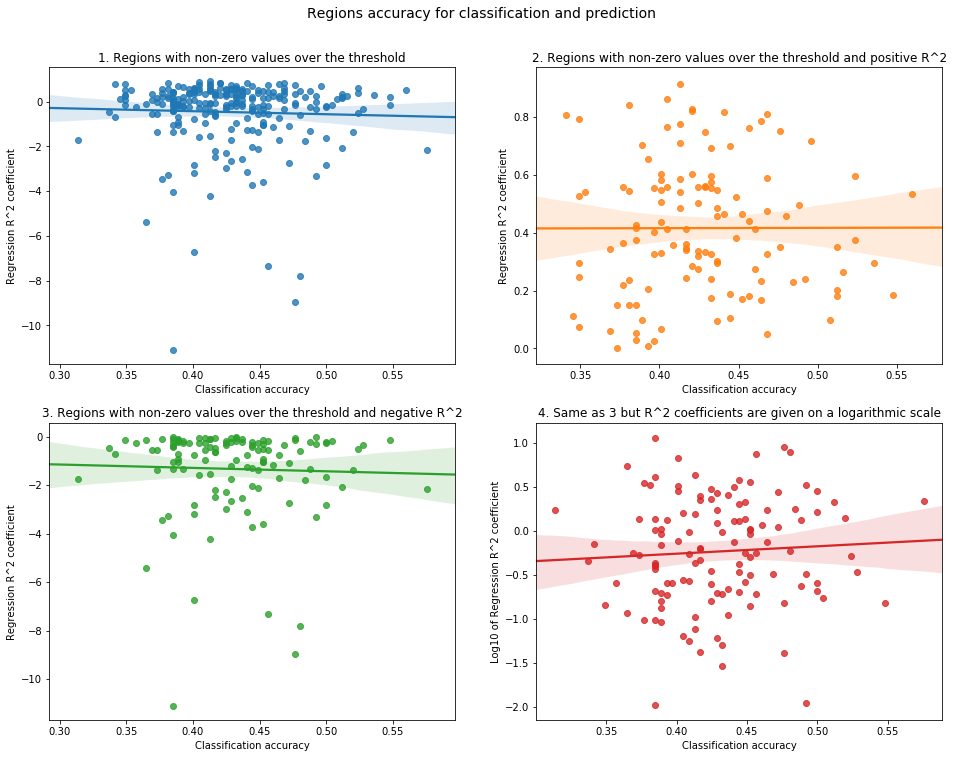

In [62]:
# Display scatter plots showing the regions accuracy for classification and prediction. 
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 12))
fig.suptitle('Regions accuracy for classification and prediction', y = 0.95, fontsize = 14)

# Regions with non-zero values over the threshold. 
sns.regplot(scores_classification_models[regions_over_threshold == 1], predictability_map[regions_over_threshold == 1], ax = axes[0, 0])
axes[0, 0].set_title('1. Regions with non-zero values over the threshold')
axes[0, 0].set_xlabel('Classification accuracy')
axes[0, 0].set_ylabel('Regression R^2 coefficient')

# Regions with non-zero values over the threshold and positive R^2. 
sns.regplot(positive_R2_scores_classification_models, positive_R2_predictability_map, ax = axes[0, 1])
axes[0, 1].set_title('2. Regions with non-zero values over the threshold and positive R^2')
axes[0, 1].set_xlabel('Classification accuracy')
axes[0, 1].set_ylabel('Regression R^2 coefficient')

# Regions with non-zero values over the threshold and negative R^2. 
sns.regplot(negative_R2_scores_classification_models, negative_R2_predictability_map, ax = axes[1, 0])
axes[1, 0].set_title('3. Regions with non-zero values over the threshold and negative R^2')
axes[1, 0].set_xlabel('Classification accuracy')
axes[1, 0].set_ylabel('Regression R^2 coefficient')

# Regions with non-zero values over the threshold and negative R^2. 
sns.regplot(negative_R2_scores_classification_models, np.log10(-negative_R2_predictability_map), ax = axes[1, 1])
axes[1, 1].set_title('4. Same as 3 but R^2 coefficients are given on a logarithmic scale')
axes[1, 1].set_xlabel('Classification accuracy')
axes[1, 1].set_ylabel('Log10 of Regression R^2 coefficient');

**Result:** For the selected regions, there seem to be no correlation between the classification accuracy and the regression accuracy, even if we divide the data according to the R^2 coefficient value. Therefore, in our case, the best regions for classification are independent from the best regions for regression. 